{/* cspell:ignore workstreams workstream xvals yvals xval Arunachalam scikit */}

# Quantum Kernels

## Introduction to quantum kernels

The "Quantum kernel method" refers to any method that uses quantum computers to estimate a kernel. In this context, "kernel" will refer to the kernel matrix or individual entries therein. Recall that a feature mapping $\Phi(\vec{x})$ is a mapping from $\vec{x}\in \mathbb{R}^d$ to $\Phi(\vec{x})\in \mathbb{R}^{d'},$ where usually $d'>d$ and where the goal of this mapping is to make the categories of data separable by a hyperplane. The kernel function takes vectors in the feature-mapped space as arguments and returns their inner product, that is, $K:\mathbb{R}^d\times\mathbb{R}^d\rightarrow \mathbb{R}$ with $K(x,y) = \langle \Phi(x)|\Phi(y)\rangle$. Classically, we are interested in feature maps for which the kernel function is easy to evaluate. This often means finding a kernel function for which the inner product in the feature-mapped space can be written in terms of the original data vectors, without having to ever construct $\Phi(x)$ and $\Phi(y)$. In the method of quantum kernels, the feature mapping is done by a quantum circuit, and the kernel is estimated using measurements on that circuit and the relative measurement probabilities.

In this lesson we will examine the depths of pre-coded encoding circuits that use substantial entanglement and compare those to depths of circuits we code by hand. This is not to advocate for one method over another. You may find that pre-coded circuits are too deep, and that the entanglement in the custom-built circuit is insufficient to be useful. Again, these are shown only to enable your exploration.

Before walking through a kernel matrix estimation in detail, let us outline the workflow using the language of Qiskit patterns.

### Step 1: Map classical inputs to a quantum problem

*   Input: Training dataset
*   Output: Abstract circuit for calculating a kernel matrix entry

Given the dataset, the starting point is to encode the data into a quantum circuit. In other words, we need to map our data into the Hilbert space of states of our quantum computer. We do this by constructing a data-dependent circuit. There are many ways of doing this, and the previous lesson outlined a number of options. You can construct your own circuit to encode your data, or you can use a pre-made feature map like `zz_feature_map`. In this lesson, we will do both.

Note that in order to calculate a single kernel matrix element, we will want to encode two different points, so we can estimate their inner product. A full quantum kernel workflow will of course, involve many such inner products between mapped data vectors, as well as classical machine learning methods. But the core step being iterated is the estimation of a single kernel matrix element. For this we select a data-dependent quantum circuit and map two data vectors into the feature space.

![Classical\_Review\_background\_kernel\_circuit](/learning/images/courses/quantum-machine-learning/quantum-kernel-methods/classical-review-background-kernel-circuit.avif)

For the task of generating a kernel matrix, we are particularly interested in the probability of measuring the $|0\rangle^{\otimes N}$ state, in which all $N$ qubits are in the $|0\rangle$ state. To see this, consider that the circuit responsible for encoding and mapping of one data vector $\vec{x}_i$ can be written as $\Phi(\vec{x}_i)$, and the one responsible for encoding and mapping $\vec{x}_j$ is $\Phi(\vec{x}_j)$, and denote the mapped states

$$
|\psi(\vec{x}_i)\rangle = \Phi(\vec{x}_i)|0\rangle^{\otimes N}
$$

$$
|\psi(\vec{x}_j)\rangle = \Phi(\vec{x}_j)|0\rangle^{\otimes N}.
$$

These states *are* the mapping of the data to higher dimensions, so our desired kernel entry is the inner product

$$
\langle\psi(\vec{x}_j)|\psi(\vec{x}_i)\rangle = \langle 0 |^{\otimes N}\Phi^\dagger(\vec{x}_j)\Phi(\vec{x}_i)|0\rangle^{\otimes N}.
$$

If we operate on the default initial state $|0\rangle^{\otimes N}$ with both circuits $\Phi^\dagger(\vec{x}_j)$ and $\Phi(\vec{x}_i)$, the probability of then measuring the state $|0\rangle^{\otimes N}$ is

$$
P_0 = |\langle0|^{\otimes N}\Phi^\dagger(\vec{x}_j)\Phi(\vec{x}_i)|0\rangle^{\otimes N}|^2.
$$

This is exactly the value we want (up to $||^2$). The measurement layer of our circuit will return measurement probabilities (or so-called "quasi-probabilities", if certain error mitigation methods are used). The probability of interest is that of the zero state, $|0\rangle^{\otimes N}$.

### Step 2: Optimize problem for quantum execution

*   Input: Abstract circuit, not optimized for a particular backend
*   Output: Target circuit and observable, optimized for the selected QPU

In this step, we will use the `generate_preset_pass_manager` function from Qiskit to specify an optimization routine for our circuit with respect to the real quantum computer on which we plan to run the experiment. We set `optimization_level=3` , which means we will use the preset pass manager which provides the highest level of optimization. In this context, "optimization" refers to optimizing the implementation of the circuit on a real quantum computer. This includes considerations like selecting physical qubits to correspond to qubits in the abstract quantum circuit that will minimize gate depth, or selecting physical qubits with the lowest available error rates. This is not directly related to optimization of the machine learning problem (as in classical optimizers like COBYLA).

Depending on how you implement step 2, you may have to optimize the circuit more than once, since each pair of points involved in a matrix element produce a different circuit to be measured.

### Step 3: Execute using Qiskit Runtime Primitives

*   Input: Target circuit
*   Output: Probability distribution

Use the `Sampler` primitive from Qiskit Runtime to reconstruct a probability distribution of states yielded from sampling the circuit. Note that you may see this referred to as a "quasi-probability distribution", a term which is applicable where noise is an issue and when extra steps are introduced, such as in error mitigation. In such cases, the sum of all probabilities may not exactly equal 1; hence "quasi-probability".

### Step 4: Post-process, return result in classical format

*   Input: Probability distribution
*   Output: A single kernel matrix element, or a kernel matrix if repeating

Calculate the probability of measuring $|0\rangle^{\otimes N}$ on the quantum circuit, and populate the kernel matrix in the position corresponding to the two data vectors used. To fill out the entire kernel matrix, we need to run a quantum experiment for each entry. Once we have a kernel matrix, we can use it in many classical machine learning algorithms that accept `pre-calculated kernels`. For example: `qml_svc = SVC(kernel="precomputed")`. We can then use classical workstreams to apply our model on our testing data, and get an accuracy score. Depending on our satisfaction with our accuracy score, we may need to revisit aspects of our calculation, such as our feature map.

### Lesson outline

In this lesson we will carry out these steps several ways to make optimal use of your time on real quantum computers. We will apply a quantum kernel method to

*   A single kernel matrix entry for data with relatively few features, using a real backend, so that we can easily follow what is happening at each step.
*   An entire data set with relatively few features, using a simulated backend, so that we can see how the quantum workstream connects with classical machine learning methods
*   A single kernel matrix entry for data with many features, using a real quantum computer. We will not estimate an entire kernel matrix for a large dataset, in order to respect time on IBM® quantum computers.



In [ ]:
# If you have not already, install scikit learn
#!pip install scikit-learn

## Single kernel matrix entry

### Step 1: Map classical inputs to a quantum problem

Let us first consider a data set with just a few features, say 10. The data set could be as large as you like, since we are calculating the kernel matrix elements one at a time. We need at least two points, so we will start with that (in the next example, we will import a full dataset). Let's import a few needed packages:



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Two mock data points, including category labels, as in training
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]

# Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]

### Practice

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Two mock data points, including category labels, as in training
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]

# Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]
train_data

[[-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143],
 [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02]]

We can try using the `z_feature_map`.



In [3]:
# from qiskit.circuit.library import zz_feature_map
# fm = zz_feature_map(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)

from qiskit.circuit.library import z_feature_map

fm = z_feature_map(feature_dimension=np.shape(train_data)[1])


unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

### Practice

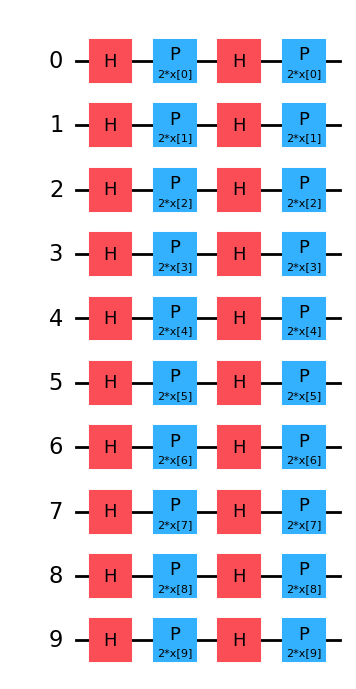

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
from qiskit.circuit.library import z_feature_map
from qiskit.quantum_info import Statevector

fm = z_feature_map(feature_dimension=np.shape(train_data)[1])

display(fm.draw("mpl", scale=1))

unitary1 = fm.assign_parameters(train_data[0])

State_qc0_1=Statevector.from_instruction(unitary1)
display(State_qc0_1 .draw("latex"))

unitary2 = fm.assign_parameters(train_data[1])

State_qc0_2=Statevector.from_instruction(unitary2)
display(State_qc0_2 .draw("latex"))

The two unitaries above exactly correspond to $U_1$ and $U_2$ described in the introduction. We can combine them using `unitary_overlap`. As always, we want to keep an eye on our circuit depth.



circuit depth =  9


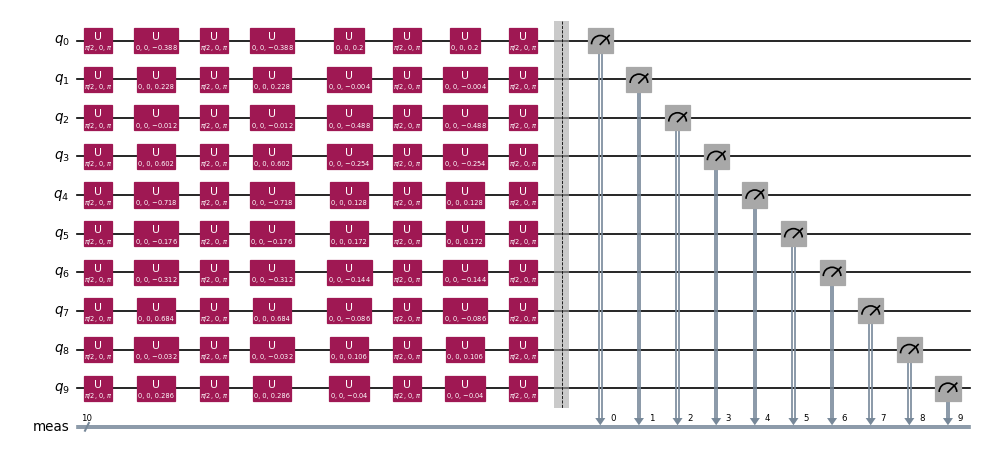

In [5]:
from qiskit.circuit.library import unitary_overlap


overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")

### Practice

<IPython.core.display.Latex object>

circuit depth =  9


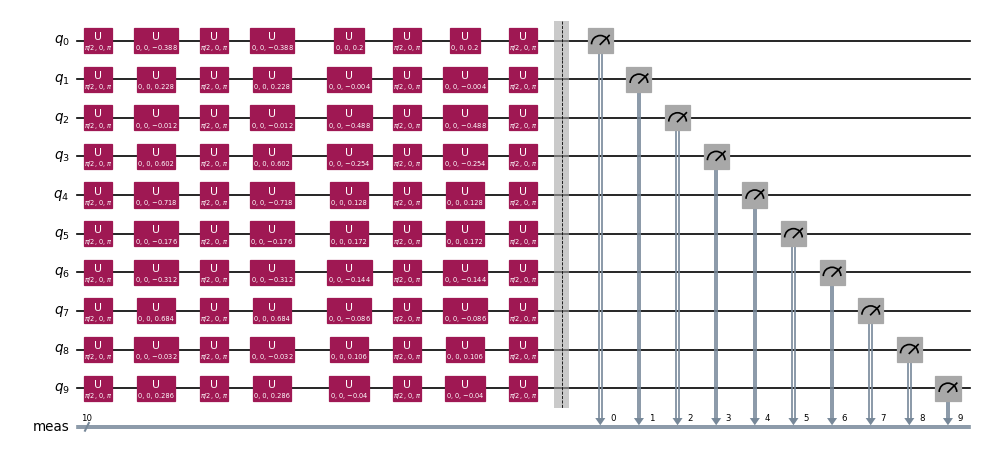

In [6]:
from qiskit.circuit.library import unitary_overlap
overlap_circ = unitary_overlap(unitary1, unitary2)

State_overlap_circ =Statevector.from_instruction(overlap_circ)
display(State_overlap_circ .draw("latex"))

overlap_circ.measure_all()
print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")

### Step 2: Optimize problem for quantum execution

We start by selecting the least busy backend, then optimize our circuit for running on that backend.



In [56]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="e7h5WbHr2IxhEyYsYGFPlAJ_RRd76jLlYuZFS7qV5gIX"
)


AccountAlreadyExistsError: 'Named account (default-ibm-quantum-platform) already exists. Set overwrite=True to overwrite.'

In [8]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

qiskit_runtime_service.__init__:WARNING:2026-01-30 11:03:07,033: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-30 11:03:07,652: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-30 11:03:11,004: Using instance: open-instance, plan: open


<IBMBackend('ibm_fez')>


In [11]:
import qiskit
import qiskit_ibm_runtime

print(qiskit.__version__)
print(qiskit_ibm_runtime.__version__)

2.3.0
0.45.0


In [12]:
pip install -U qiskit qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Apply level 3 optimization to our overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

For complicated circuits, this step will substantially increase the circuit depth as it maps to native gates for real quantum computers, and information may need to be moved from qubit to qubit. In this simple case, the depth is hardly affected at all.



In [14]:
print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)

circuit depth =  10


1

### Step 3: Execute using Qiskit Runtime Primitives

The syntax for running on a simulator is commented out below. For this dataset, with a small number of features, running on a simulator is still an option. For utility-scale calculations, simulation is not typically feasible. Simulators should only be used to debug scaled-down code.



0.8366


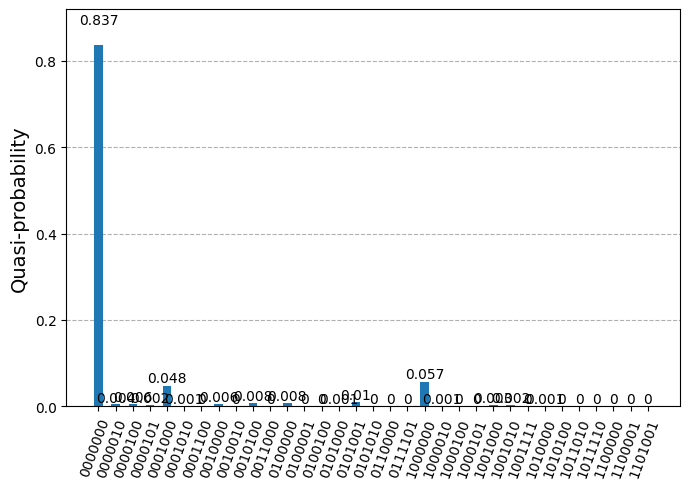

In [29]:
# Run this for a simulator
from qiskit.primitives import StatevectorSampler

from qiskit_ibm_runtime import Options, Session, Sampler

num_shots = 10000

# Evaluate the problem using state vector-based primitives from Qiskit
sampler = StatevectorSampler()
results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

print(counts.get(0, 0.0) / num_shots)

from qiskit.visualization import plot_distribution

plot_distribution(counts_bit)



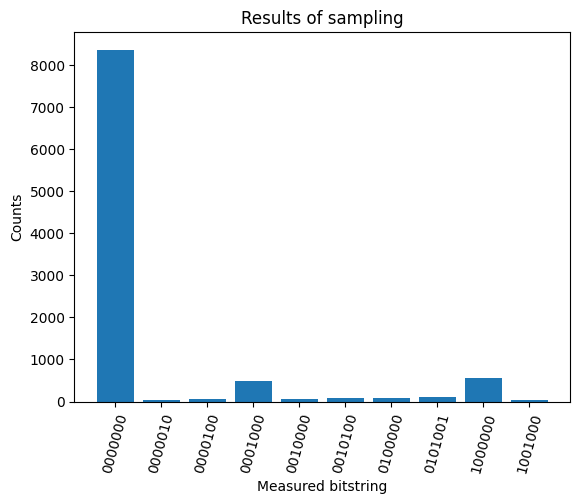

In [30]:
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()


visualize_counts(counts, overlap_circ.num_qubits)

In [ ]:
# Benchmarked on an Eagle processor, 7-11-24, took 4 sec.

# Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

num_shots = 1000

# Use sampler and get the counts

sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()
from qiskit.visualization import plot_distribution

plot_distribution(counts_bit)

### Step 4: Post-process, return result in classical format

As described in the introduction, the most useful measurement here is the probability of measuring the zero state $|00000\rangle$.



In [16]:
counts.get(0, 0.0) / num_shots

0.669

This is the outcome we wanted: an estimate of the inner product (up to mod squared) of the vectors corresponding to two data points. If we want to look at the full distribution of measurement probabilities (or quasiprobabilities), we can do so using the `plot_distribution` function as shown below. One sees that for a large number of qubits, pictures like this quickly become intractable.



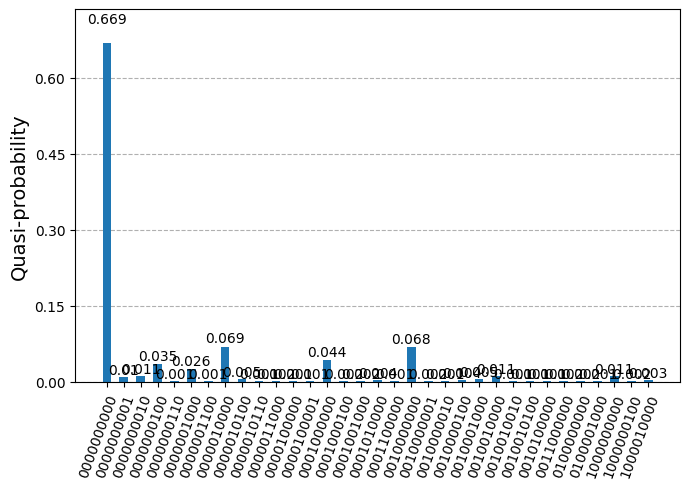

In [17]:
from qiskit.visualization import plot_distribution

plot_distribution(counts_bit)

Alternatively, one might define a visualization like the one below to look only at the top 10 most probable measurements. This could be important for troubleshooting or trying to glean more intuition for the data. But the measurement probability of the zero state is our kernel matrix element.



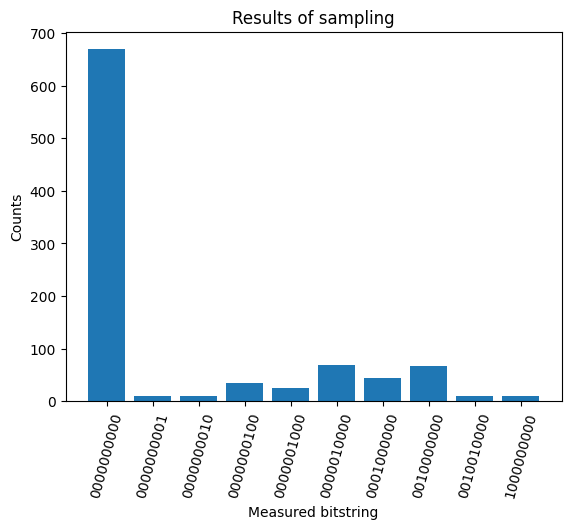

In [18]:
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()


visualize_counts(counts, overlap_circ.num_qubits)

From this information about only one inner product between two data points in the higher dimensional feature space, all we can say is that their overlap is fairly large compared to the maximum overlap (which would be 1.0). This could be an indicator that these two data points are somehow similar in nature and will be categorized in the same class classes. Or it could be an indicator that our feature map is not effective at mapping into a space where like data has a strong overlap and unlike data has a small overlap. In order to know which is true, we must apply our feature map to the entire set of data and see if the resulting kernel matrix can be manipulated to effectively separate classes with high accuracy.

It is worth noting that we used the `z_feature_map` which resulted in low two-qubit transpiled depth (depth 1, in fact). If your circuits become too deep, it is sure to result in a lot of noise, and this will make the probability of measuring the zero state very low, even if your feature map is well-matched to your data. For example, a repetition of the above process using `zz_feature_map` and `, entanglement='linear', reps=1` yielded `dist.get(0,0.0) = 0.0015` using the same data points. This is due to the much greater circuit depths and two-qubit depths from `zz_feature_map`. The figure below shows the probability distribution for that calculation.

![Bad results from a zz feature map.](/learning/images/courses/quantum-machine-learning/quantum-kernel-methods/zzfeaturemap-bad-results.avif)

It is worth playing around with a few data points from the same category to see how low your depth must be to obtain good results. The following is rough advice that is sure to have exceptions. Generally, a two-qubit, transpiled depth of 10 or fewer should be no problem. A two-qubit, transpiled depth of 50-60 is state-of-the-art and will require advanced error mitigation among other tools. In between, your results may vary with data similarity, feature map expressivity, circuit width, and other factors.



Ordinarily the post-processing step would also include classical machine learning processes. In the next section we will extend this process to an entire dataset, and show the classical machine learning workflow.



#### Check your understanding

Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
  <summary>
    In a 10-qubit quantum circuit, generally, how many different states are there that could possibly be measured?
  </summary>

  **Answer:**

  $2^{10}$ or 1024.
</details>

<details>
  <summary>
    Let us suppose that someone new to quantum computing attempts to use a quantum circuit that has very high two-qubit depth, and they do not use error mitigation. Let us further suppose that this results in an error rate of 10% on each qubit. If the true (error-free) kernel matrix element corresponding to this circuit is very large, say 1.0, what would be the probability of measuring all 10 qubits to be in the state with every qubit |0>?
  </summary>

  **Answer:**

  The probability of each qubit being correctly found in the |0> state is 0.90. The probability for all 10 qubits to be found in the correct state is $0.90^{10}$ or about 35%.
</details>

<details>
  <summary>
    Explain in your own words why it is so important to monitor circuit depths. This is true generally, but explain it in the context of quantum kernel estimation.
  </summary>

  **Answer:**

  In this QKE workflow, our estimates are based on the measurements of the zero state, meaning the state in which every qubit is found in the $|0\rangle$ state. Very deep circuits will introduce high error rates. When that error rate is compounded over many qubits, this will reduce the probability of measuring the zero state, substantially.
</details>



## Full kernel matrix

In this section, we will extend the above process to the binary classification of a full dataset. This will introduce two important components: (1) we can now implement classical machine learning in post-processing, and (2) we can obtain accuracy scores for our training.

### Step 1: Map classical inputs to a quantum problem

Now we will import an existing dataset for our classification. This dataset consists of 128 rows (data points) and 14 features on each point. There is a 15th element that indicates the binary category of each point ($\pm 1$). The dataset is imported below, or you can access the dataset and view its structure [here](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/data/dataset_graph7.csv).

We will use the first 90 data points for training, and the next 30 points for testing.



In [31]:


df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)

# Prepare training data

train_size = 90
X_train = df.values[0:train_size, :-1]
train_labels = df.values[0:train_size, -1]

# Prepare testing data
test_size = 30
X_test = df.values[train_size : train_size + test_size, :-1]
test_labels = df.values[train_size : train_size + test_size, -1]

In [35]:
print(X_test.shape), print(X_test)

(30, 14)
[[-1.69463132 -0.23183058  0.14521057 -1.29644599 -0.09002133 -0.00638674
  -0.22792655 -1.2237305  -1.31078574 -1.64134026 -1.23031585  0.18562645
  -1.65694581 -1.74866714]
 [-1.45085421  0.07828524 -1.57840678 -0.02512897 -0.18438958 -0.11919816
  -1.33614379  0.05477239 -0.20409181 -1.57828625  0.13222959 -0.12096258
  -1.59936815 -0.18749334]
 [-0.10450599  0.32841082 -0.01804137 -1.41543429 -0.43566468  0.04788784
  -1.8776415  -1.74315519 -1.5854365  -0.02573786 -1.3873102   0.01943702
  -1.487659   -1.55479085]
 [-1.77763106 -1.47498987 -0.13784927  0.0971913  -1.5446593  -0.00434571
  -1.30091427 -1.34208916 -0.01443843  0.11013935 -0.04458907 -1.94780734
  -1.78390463 -0.15398623]
 [-1.87522101 -0.03027948  0.15771893 -1.29752586 -0.44663606 -1.50795152
  -1.78163672 -1.74225538 -1.4904222  -0.02957937 -1.09795612  0.11585309
  -1.59965852 -1.68481489]
 [-1.41374627 -1.43922374 -1.60621243  0.24636713 -1.67273146  0.00226868
  -1.31652673 -1.26239831 -0.17771976 -1.8

(None, None)

In [33]:
print(test_labels)

[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]


We will already prepare for storing multiple outputs by constructing a kernel matrix and a test matrix of appropriate dimensions.



In [36]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

In [39]:
print(f"Kernal matrix shape : {kernel_matrix.shape}"), print(f"test_matrix shape: {test_matrix.shape}")

Kernal matrix shape : (90, 90)
test_matrix shape: (30, 90)


(None, None)

Now we create a feature map for encoding and mapping our classical data in a quantum circuit. We are free to construct our own feature map or use a pre-fabricated one. Feel free to modify the feature map below, or switch back to ZFeatureMap. But always pay attention to circuit depth. Recall that in the previous 6-qubit example the transpiled circuit depth was intractably high when using `zz_feature_map`. As the scale and complexity of the circuit increase, the depth could rapidly increase to a point where noise overwhelms our results. Whenever you know something about your data structure that may inform what feature map structure would be most useful, it is advisable to create your own custom feature map that leverages that knowledge.



In [40]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)

# To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

### Steps 2 and 3: Optimize problem and execute using primitives

We will construct an overlap circuit, and if we were running on a real quantum computer in this example, we would optimize it for execution as before. But in this case, we intend to step over all data points and calculate the full kernel matrix. For each pair of data vectors $\vec{x}_i$ and $\vec{x}_j$, we create a different overlap circuit. Thus we must optimize our circuit for each data point pair. So steps 2 and 3 would be done together in the multiple iterations.

The code cell below does exactly the same process as before for a single data point pair. This time it is simply executed inside two `for` loops, and there is the additional line at the end `kernel_matrix[x_1,x_2] = ...` to store the results of each calculation. Note that we have leveraged the symmetry of a kernel matrix to reduce the number of calculations by 1/2. We have also simply set the diagonal elements to 1, as they should be in the absence of noise. Depending on your implementation and required precision, you could also use the diagonal elements to estimate noise or learn about it for error mitigation purposes.

Once the kernel matrix has been fully populated, we repeat the process for the test data and populate the test\_matrix. This is really also a kernel matrix; we simply give it a different name to distinguish the two.



In [41]:
# To use a simulator
from qiskit.primitives import StatevectorSampler

# Remember to insert your token in the QiskitRuntimeService constructor to use real quantum computers
# service = QiskitRuntimeService()
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )

num_shots = 1000
# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()

for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()

        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )

        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1

print("training done")

# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()

        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )

        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots

print("test matrix done")

training done
test matrix done


### Step 4: Post-process, return result in classical format

Now that we have a kernel matrix and a similarly formatted test\_matrix from quantum kernel methods, we can apply classical machine learning algorithms to make predictions about our test data and check its accuracy. We will start by importing Scikit-Learn's `sklearn.svc`, a support vector classifier (SVC). We must specify that we want the SVC to use our precomputed kernel using `kernel = precomputed`.



In [42]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC

# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

Using `SVC.fit`, we can now feed in the kernel matrix and the training labels to obtain a fit. `SVC.score` will then score our test data against that fit using our test\_matrix, and return our accuracy.



In [43]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)

# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


We see that the accuracy of our trained model was 100%. This is great, and it shows that QKE can work. But that is very different from quantum advantage. Classical kernels would likely have been able to solve this classification problem with 100% accuracy as well. There is much work to be done characterizing different data types and data relationships to see where quantum kernels will be most useful in the current utility era.
We leave it to the learner to modify parts of this workflow and study the effectiveness of various quantum feature maps. Here are a few things to consider:

*   How robust is the accuracy? Does it hold for broad types of data or just this specific training data?
*   What structure in your data makes you suspect that a quantum feature map is useful?
*   How is the accuracy affected by increasing/decreasing the amount of training data?
*   What feature maps can you use and how do the results vary with feature maps?
*   How are the accuracy and running time affected by increasing the number of features?
*   Which trends, if any, do you expect to hold on real quantum computers?



## Scaling to more features and qubits

In this section, we will repeat the calculation of a single matrix element, but for a much larger number of features, sketching the path to scale toward utility. The restriction to a single matrix element is done so that the process can be shown without using up too much of your allotted time on quantum computers.

### Step 1: Map classical inputs to a quantum problem

We will assume a starting point of a dataset in which each data point has 42 features. As in the first example, we will calculate a single kernel matrix element, requiring two data points. The two points below have 42 features and a single category variable ($\pm 1$).



In [44]:
# Two mock data points, including category labels, as in training

large_data = [
    [
        -0.028,
        -1.49,
        -1.698,
        0.107,
        -1.536,
        -1.538,
        -1.356,
        -1.514,
        -0.109,
        -1.8,
        -0.122,
        -1.651,
        -1.955,
        -0.123,
        -1.732,
        0.091,
        -0.048,
        -0.128,
        -0.026,
        0.082,
        -1.263,
        0.065,
        0.004,
        -0.055,
        -0.08,
        -0.173,
        -1.734,
        -0.39,
        -1.451,
        0.078,
        -1.578,
        -0.025,
        -0.184,
        -0.119,
        -1.336,
        0.055,
        -0.204,
        -1.578,
        0.132,
        -0.121,
        -1.599,
        -0.187,
        -1,
    ],
    [
        -1.414,
        -1.439,
        -1.606,
        0.246,
        -1.673,
        0.002,
        -1.317,
        -1.262,
        -0.178,
        -1.814,
        0.013,
        -1.619,
        -1.86,
        -0.25,
        -0.212,
        -0.214,
        -0.033,
        0.071,
        -0.11,
        -1.607,
        0.441,
        -0.143,
        -0.009,
        -1.655,
        -1.579,
        0.381,
        -1.86,
        -0.079,
        -0.088,
        -0.058,
        -1.481,
        -0.064,
        -0.065,
        -1.507,
        0.177,
        -0.131,
        -0.153,
        0.07,
        -1.627,
        0.593,
        -1.547,
        -0.16,
        -1,
    ],
]
train_data = [large_data[0][:-1], large_data[1][:-1]]

Recall that the `zz_feature_map` produced rather deep circuits in the case of relatively few features (14 features). As we increase the number of features, we need to closely monitor circuit depth. To illustrate this, we will first try using the `zz_feature_map` and check the depth of the resulting circuit.



In [45]:
from qiskit.circuit.library import zz_feature_map

fm = zz_feature_map(
    feature_dimension=np.shape(train_data)[1], entanglement="linear", reps=1
)

unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

circuit depth =  251
two-qubit depth 165


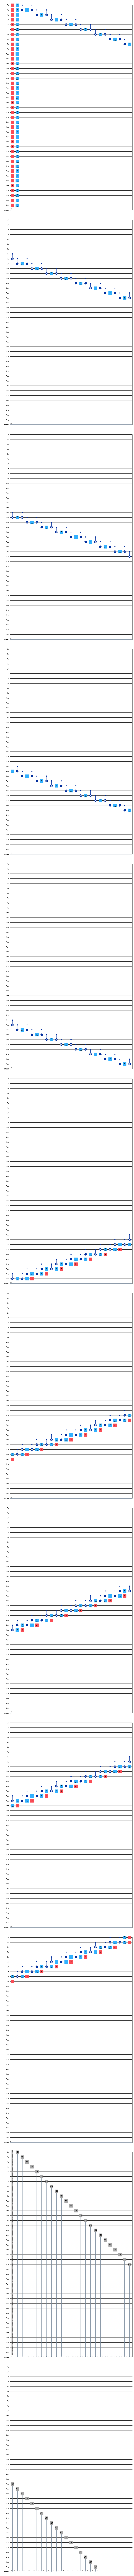

In [47]:
from qiskit.circuit.library import unitary_overlap


overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose(reps=2).depth())
print(
    "two-qubit depth",
    overlap_circ.decompose().depth(lambda instr: len(instr.qubits) > 1),
)
overlap_circ.draw("mpl", scale=0.6, style="iqp")

As described before, determining exactly how deep is too deep is nuanced. But a two-qubit depth of more than 100, even before transpilation is a non-starter. This is why custom feature maps have been emphasized throughout this lesson. If you know something about the structure of your entire dataset, you should design an entanglement map with that structure in mind. Here, since we are only calculating the inner product between two such data points, we have prioritized low circuit depth over any detailed consideration of data structure.



In [48]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap

entangler_map = [
    [3, 4],
    [2, 5],
    [1, 4],
    [2, 3],
    [4, 6],
    [7, 9],
    [10, 11],
    [9, 12],
    [8, 11],
    [9, 10],
    [11, 13],
    [14, 16],
    [17, 18],
    [16, 19],
    [15, 18],
    [16, 17],
    [18, 20],
]

In [49]:
# Use the entangler map above to build a feature map

num_features = np.shape(train_data)[1]
num_qubits = int(num_features / 2)

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

In [50]:
from qiskit.circuit.library import unitary_overlap

# Assign features of each data point to a unitary, an instance of the general feature map.

unitary1 = fm.assign_parameters(list(train_data[0]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(train_data[1]) + [np.pi / 2])

# Create the overlap circuit

overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()

We won't bother checking the depths yet, since what really matters is the transpiled two-qubit depth.



### Step 2: Optimize problem for quantum execution

We start by selecting the least busy backend, then optimize our circuit for running on that backend.



In [ ]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)


qiskit_runtime_service.__init__:WARNING:2026-01-30 12:19:21,950: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-30 12:19:22,571: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-30 12:19:25,391: Using instance: open-instance, plan: open


<IBMBackend('ibm_fez')>


On small-scale jobs, a preset pass manager will often return the same circuit with the same depth, reliably. But in very large, complex circuits the pass manager can return different transpiled circuits each time it runs. This is because it is using heuristics, and because very large circuits will have a complicated landscape of possible optimizations. It is often useful to transpile a few times and take the shallowest circuit. This only introduces classical overhead and may substantially improve the results from the quantum computer.

Here, we transpile the unitary overlap circuit 20 times, and look at the depths of the circuits obtained.



In [52]:
# Apply level 3 optimization to our overlap circuit
transpiled_qcs = []
transpiled_depths = []
transpiled_twoqubit_depths = []
for i in range(1, 20):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    overlap_ibm = pm.run(overlap_circ)
    transpiled_qcs.append(overlap_ibm)
    transpiled_depths.append(overlap_ibm.decompose().depth())
    transpiled_twoqubit_depths.append(
        overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)
    )

print("circuit depth = ", overlap_ibm.decompose().depth())

circuit depth =  36


In [53]:
print(transpiled_depths)
print(transpiled_twoqubit_depths)

[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


Here you can see that there is some variation in the total gate depth with different transpilation passes. Our circuit is not yet deep/wide enough to see variation in the two-qubit transpiled depths. We will use the `transpiled_qcs[1]`, which has a depth of 60, just slightly lower than the depth of the deepest circuit obtained, which was 77.



In [54]:
overlap_ibm = transpiled_qcs[1]

### Step 3: Execute using Qiskit Runtime Primitives

As we scale closer to utility, simulators will not be useful. Only the syntax for real quantum computers is shown here.



In [55]:
# Run on ibm_osaka, 7-12-24, required 22 sec.

# Import our runtime primitive
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Open a Runtime session:
session = Session(backend=backend)
num_shots = 1000
# Use sampler and get the counts

sampler = Sampler(mode=session)
options = sampler.options
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True
counts = (
    sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
)

# Close session after done
session.close()

RequestsApiError: '400 Client Error: Bad Request for url: https://quantum.cloud.ibm.com/api/v1/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"be847c9c-1fe3-4424-8e06-98f19b7fcbce"}\n'

## Correct Code (session need to be removed for free instances)

In [58]:
# Run on ibm_osaka, 7-12-24, required 22 sec.

# Import our runtime primitive
from qiskit_ibm_runtime import SamplerV2 as Sampler


num_shots = 1000
# Use sampler and get the counts

sampler = Sampler(mode=backend)
options = sampler.options
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True
counts = (
    sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
)


### Step 4: Post-process, return result in classical format

As described in the introduction, the most useful measurement here is the probability of measuring the zero state $|00000\rangle$.



In [59]:
counts.get(0, 0.0) / num_shots

0.016

This process for the single kernel matrix element could be repeated between other data pairs in your set to obtain the full kernel matrix. The dimension of the kernel matrix is dictated by the number of points in your training data, not the number of features. So the computing cost of manipulating the kernel matrix into a predictive model does not scale like the number of features or qubits. Even for relatively small datasets with large numbers of features, the data would still need to be matched to a feature map that yields effective classification.

### Scaling and future work

The kernel method requires that we measure the $|0\rangle$ as accurately as possible. But gate errors and readout errors mean that there is some non-zero probability $p$ that any given qubit will be erroneously measured to be in the $|1\rangle$ state. Even with the oversimplification that the probability of $|0\rangle$ should be $100\%$, for many features encoded on, say, $N$ bits, the probability of correctly measuring all bits to be $|0\rangle$ is reduced to $(1-p)^N$. As $N$ becomes large, this method becomes less and less reliable. Overcoming this difficulty and scaling kernel estimation to more and more features is an area of current research. To learn more about this issue, see this work by [Thanasilp, Wang, Cerezo, and Holmes.](https://www.nature.com/articles/s41467-024-49287-w) We recommend you explore what can be done with current quantum computers, and also look forward to what will be possible in the era of error correction.



### Review

Calculating a quantum kernel involves

*   calculating kernel matrix entries, using pairs of training data points
*   encoding the data and mapping it via a feature mapping
*   optimizing your circuit for running on real quantum computers / backends

The quantum kernel can then be used in classical machine learning algorithms, as in this lesson.

Some key things to keep in mind when using quantum kernels include:

*   Is the dataset likely to benefit from quantum kernel methods?
*   Try different feature maps and entanglement schemes.
*   Is the circuit depth acceptable?
*   Try running a pass manager multiple times and use the smallest-depth circuit you can get.

Quantum kernel methods are potentially powerful tools given a proper match between datasets with quantum-amenable features, and a suitable quantum feature map. To better understand where quantum kernels are likely to be useful, we recommend reading [Liu, Arunachalam & Temme (2021)](https://www.nature.com/articles/s41567-021-01287-z).



© IBM Corp., 2017-2026